# Augmentation de data spectogramme

In [1]:
import zipfile
from os import listdir
import glob
import os
import sys

import numpy as np
from scipy.io import wavfile
from scipy import signal
import librosa
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import pandas as pd

import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Reshape, GRU
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

import h5py

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")



C:\ProgramData\Anaconda33\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Plot parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'

# Loading data from drive

We need to have uploaded the file on the Drive and right click to create a shareable link. The id can be found at the end of the url. This id must be used in the following cells (replacing the one I used from my Drive).

In [3]:
print(os.listdir('../input'))


['bird_data.h5', 'ff1010bird_metadata.csv', 'ff1010bird_wav.zip', 'model_bird.h5', 'warblrb10k_public_metadata.csv', 'warblrb10k_public_wav.zip', 'wav']


In [5]:
all_path = listdir('../input/wav')
all_path = ['../input/wav/' + x for x in all_path]

In [6]:
len(all_path)

15690

## Load labels

In [7]:
#y1 = pd.read_csv('/content/drive/My Drive/ff1010bird_metadata.csv')
#y2 = pd.read_csv('/content/drive/My Drive/warblrb10k_public_metadata.csv')
y1 = pd.read_csv('../input/ff1010bird_metadata.csv')
y2 = pd.read_csv('../input/warblrb10k_public_metadata.csv')

y_df = pd.concat([y1, y2])
y_df['itemid'] = y_df['itemid'].astype(str)
y = y_df.sort_values('itemid')['hasbird'].values

# Audio preprocessing

In [12]:
def load_wav(pathList, num, decimate=None):
    """
        Load audio data.

        Parameters
        ----------
        pathList : list
            List of wav file paths.
        num : int
            What file to choose among the list of path.
        decimate : int
            If not None, downsampling by a factor of `decimate` value.

        Returns:
        -------
        S : array-like
            Array of shape (Mel bands, time) containing the spectrogram.
    """
    # Load data
    fs, data = wavfile.read(pathList[num])

    data = data.astype(np.float32)

    if decimate is not None:
        data = signal.decimate(data, decimate)
        fs /= decimate

    return fs, data


def create_spec(data, fs, n_mels = 32, n_fft = 2048, hop_len = 1024):
    """
        Compute the Mel spectrogram from audio data.

        Parameters
        ----------
        data : array-like
            Audio data.
        fs : int
            Sampling frequency in Hz.
        n_mels : int
            Number of Mel bands to generate.
        n_fft : int
            Length of the FFT window.
        hop_len : int
            Number of samples between successive frames.

        Returns:
        -------
        S : array-like
            Array of shape (Mel bands, time) containing the spectrogram.
    """
    # Calculate spectrogram
    S = librosa.feature.melspectrogram(
      data, sr=fs, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)
    S = S.astype(np.float32)

    # Convert power to dB
#     S = np.log(S * 10 + 0.001)
    S = librosa.power_to_db(S)

    return S
  
def plot_spec(S):
    """
        Plot a spectrogram.

        Parameters
        ----------
        S : array-like
            Spectrogram.
    """
    pylab.rcParams['figure.figsize'] = (20, 2)
    
    plt.figure()
    plt.imshow(S, cmap=plt.get_cmap('inferno'), aspect='auto', origin='lower')
    plt.axis('off')
    plt.show()
    plt.close()

## Test labels: check labels

### Sound examples

In [9]:

#fs, data = load_wav(['./wav/19257.wav'], 0)
fs, data = load_wav(['../input/wav/19257.wav'], 0)


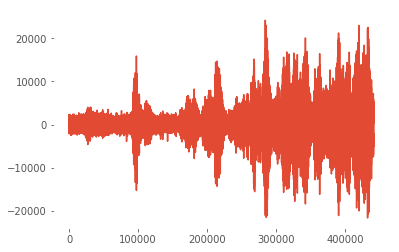

In [10]:
plt.plot(data)

## Creating MEL spectrograms

In [14]:
fs = 44100
# From Cakir
N_MELS = 40

# MEL spec from STFT 40 ms and 20 ms overlap
N_FFT = int(0.04 * fs) + 1
HOP_LEN = int(0.02 * fs) + 1

In [15]:
S = create_spec(data[:(44100 * 10)], fs, n_mels = N_MELS, n_fft = N_FFT, hop_len = HOP_LEN)
print(type(S), S.shape)

<class 'numpy.ndarray'> (40, 500)


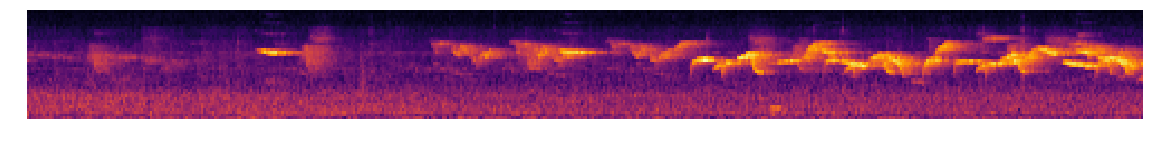

In [16]:
plot_spec(S)

In [22]:
S.shape

(40, 500)

In [24]:

import IPython.display as ipd
ipd.Audio('../input/wav/19257.wav')


## Augmentation de data spectogramme


In [29]:
datagen_list = None
def init_datagen():
    """ initialisation des des générateurs d'augmentation """
    """ ces paramétrages seront à revoir à l'épreuve des tests """
    global datagen_list
    
    datagen_width_shift = ImageDataGenerator(width_shift_range=[-30,30])
    #datagen_height_shift = ImageDataGenerator(height_shift_range=0.5) # sur l'axe des frequences ne convient pas, non ?
    datagen_horizontal_flip = ImageDataGenerator(horizontal_flip=True)
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    
    datagen_list = [datagen_width_shift, datagen_horizontal_flip, datagen_brightness]

def datagen_augmentation(S, y, my_range=5, to_display=False):
    """ augmentation """
    """ input: S= 1 spectogramme """
    """ inpout: y du spectograme """
    """ output: liste de nouveaux Spectogrammes avec la liste de Y (duppliquée de l'input)"""
    """ nb. le spectogramme d'input n'est pas en sortie, après c'est si on veut, question de confort/friendly """
    
    """ par defaut 5 spectogrames générés par generateur """
    """ avec 3 generateurs :"""
    """ - cela fait 15 spectogrammes pour 1 spectogramme """
    
    global datagen_list
    if datagen_list is None:
        init_datagen()
        
    list_S = []
    list_y = []
    for datagen in datagen_list:
        data = np.expand_dims(S, axis=2) 

        # expand dimension to one sample
        samples = expand_dims(data, 0) 
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot
        for i in range(my_range):
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            image = image[:,:,0]
            list_S.append(image)
            list_y.append(y)
            if to_display==True:
                plot_spec(image)
    return list_S, list_y



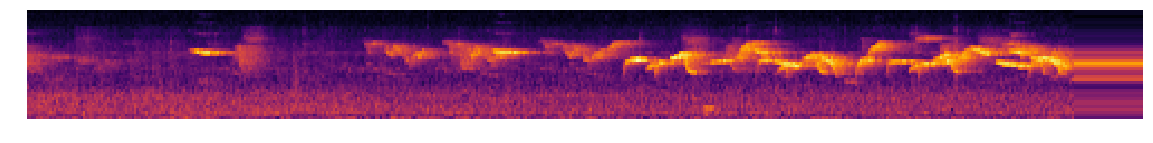

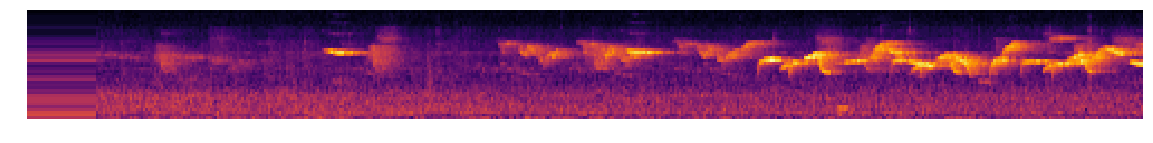

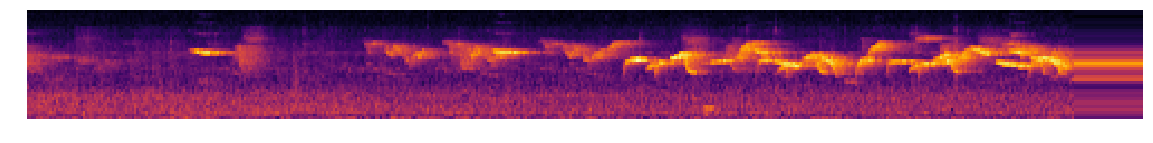

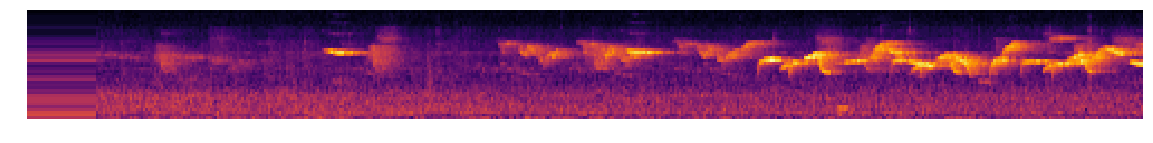

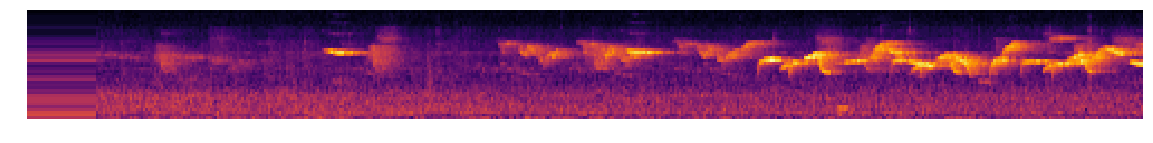

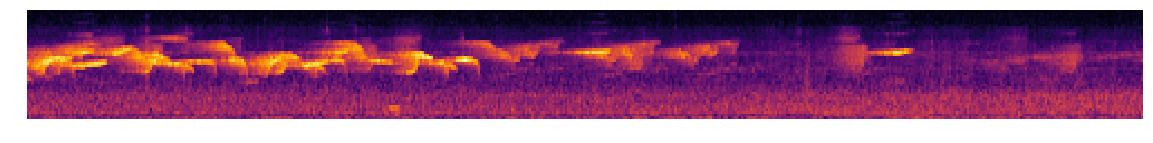

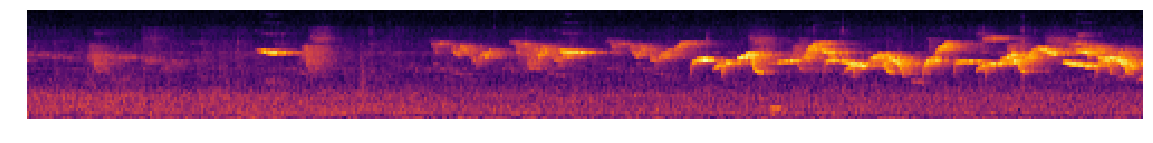

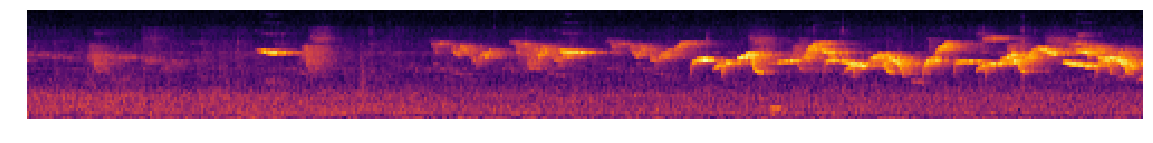

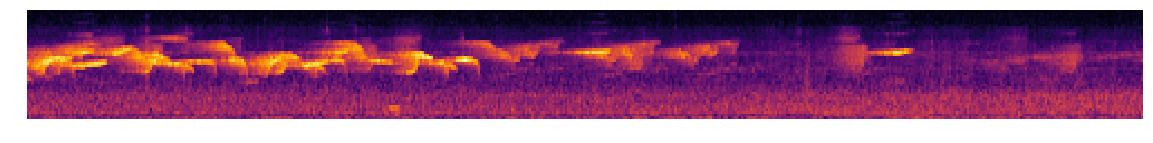

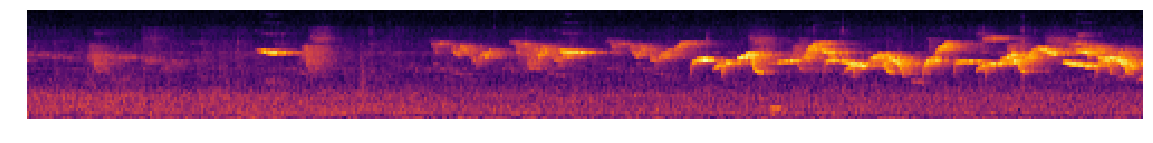

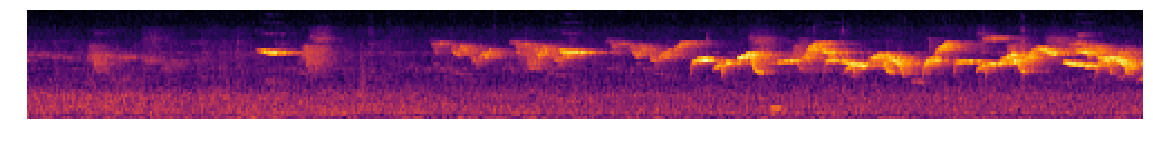

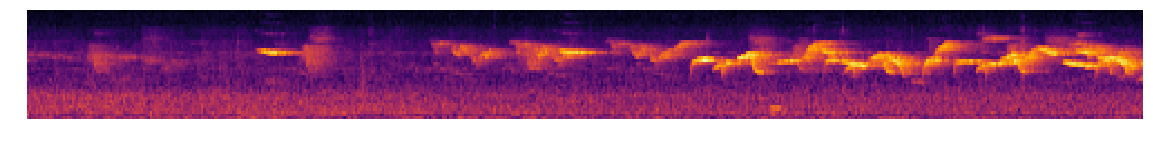

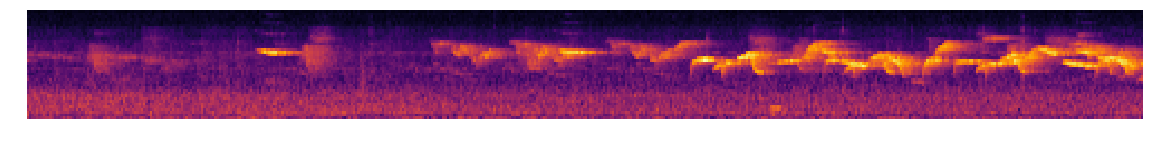

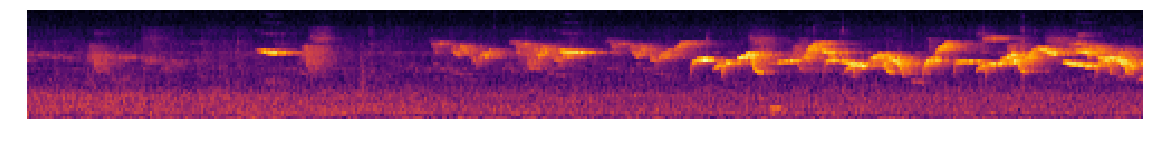

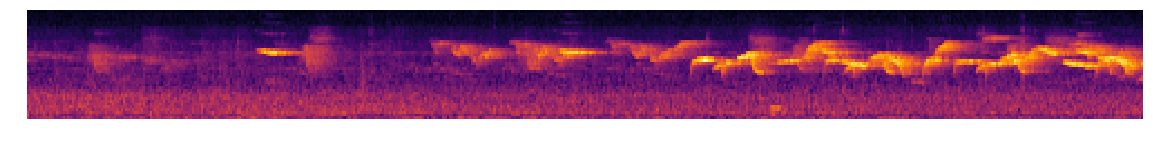

--> 15  nouveaux spectogrammes


In [30]:
def datagen_test(S):
    """ test d augmentation des data"""
    y = 1 
    list_S, list_y = datagen_augmentation(S, y, 5, True)
    print('-->',len(list_S), ' nouveaux spectogrammes')
    
datagen_test(S)    


In [31]:
print('-end')

-end
